In [1]:
#Credit Card Fraud Detection: Model Comparison and Analysis

#1.Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')


In [2]:
#2.Load & Preprocess Dataset
df = pd.read_csv("creditcard.csv")

#Standardize Time & Amount
df['NormalizedAmount'] = StandardScaler().fit_transform(df[['Amount']])
df['NormalizedTime'] = StandardScaler().fit_transform(df[['Time']])
df.drop(['Time', 'Amount'], axis=1, inplace=True)

#Features & Labels
X = df.drop('Class', axis=1)
y = df['Class']

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

#Basic Undersampling for balance (removing most non-fraud)
fraud_idx = y_train[y_train == 1].index
normal_idx = y_train[y_train == 0].sample(len(fraud_idx), random_state=42)
undersample_idx = fraud_idx.union(normal_idx)

X_train_under = X_train.loc[undersample_idx]
y_train_under = y_train.loc[undersample_idx]


In [3]:
#3.Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, random_state=42)
}

results = {}


In [4]:
#4.Train & Evaluate Models
for name, model in models.items():
    model.fit(X_train_under, y_train_under)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\nResults for {name}")
    print(classification_report(y_test, y_pred, digits=4))
    
    results[name] = {
        "confusion": confusion_matrix(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob),
        "fpr": roc_curve(y_test, y_prob)[0],
        "tpr": roc_curve(y_test, y_prob)[1],
        "precision": precision_recall_curve(y_test, y_prob)[0],
        "recall": precision_recall_curve(y_test, y_prob)[1]
    }



Results for Logistic Regression
              precision    recall  f1-score   support

           0     0.9995    0.0611    0.1151     71079
           1     0.0018    0.9837    0.0036       123

    accuracy                         0.0627     71202
   macro avg     0.5007    0.5224    0.0594     71202
weighted avg     0.9978    0.0627    0.1149     71202


Results for Random Forest
              precision    recall  f1-score   support

           0     1.0000    0.0000    0.0001     71079
           1     0.0017    1.0000    0.0034       123

    accuracy                         0.0018     71202
   macro avg     0.5009    0.5000    0.0018     71202
weighted avg     0.9983    0.0018    0.0001     71202


Results for XGBoost
              precision    recall  f1-score   support

           0     1.0000    0.0172    0.0337     71079
           1     0.0018    1.0000    0.0035       123

    accuracy                         0.0189     71202
   macro avg     0.5009    0.5086    0.0186    

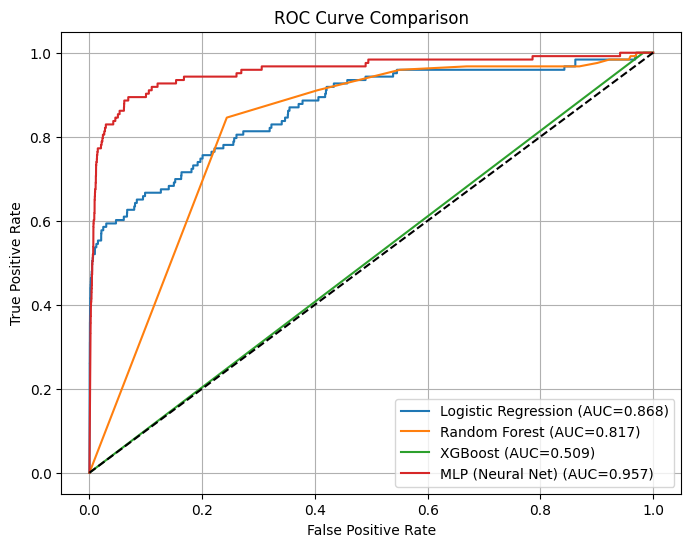

In [5]:
#5.Plot ROC Curves
plt.figure(figsize=(8, 6))
for name, res in results.items():
    plt.plot(res["fpr"], res["tpr"], label=f'{name} (AUC={res["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()


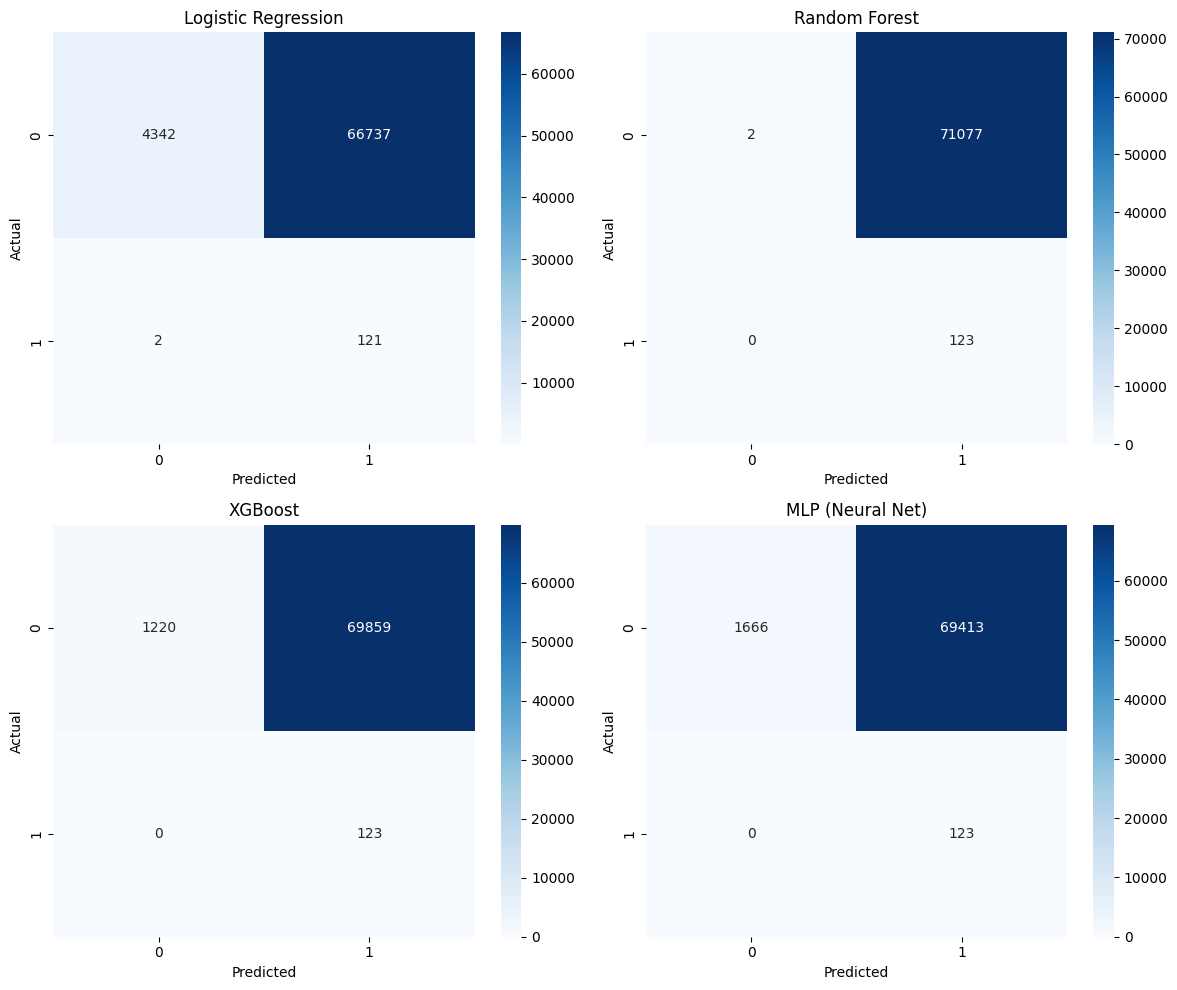

In [6]:
#6.Plot Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
for i, (name, res) in enumerate(results.items()):
    sns.heatmap(res["confusion"], annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
plt.tight_layout()
plt.show()


In [7]:
#7.Summary
for name, res in results.items():
    print(f"{name}:")
    print(f"ROC AUC Score: {res['roc_auc']:.4f}")


Logistic Regression:
ROC AUC Score: 0.8678
Random Forest:
ROC AUC Score: 0.8174
XGBoost:
ROC AUC Score: 0.5086
MLP (Neural Net):
ROC AUC Score: 0.9565


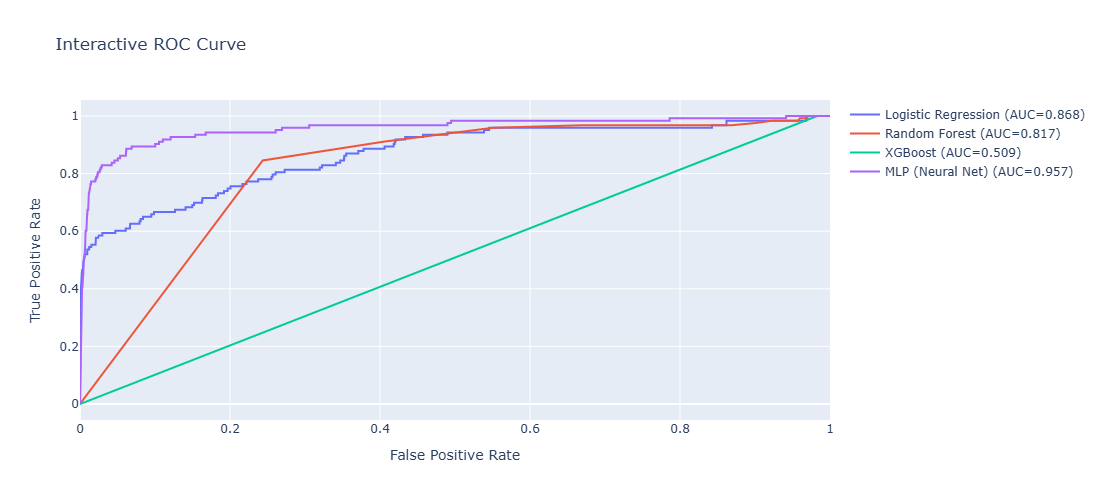

In [8]:
import plotly.graph_objects as go

#Plotly ROC Curve
fig = go.Figure()
for name, res in results.items():
    fig.add_trace(go.Scatter(
        x=res['fpr'],
        y=res['tpr'],
        mode='lines',
        name=f"{name} (AUC={res['roc_auc']:.3f})"
    ))

fig.update_layout(
    title="Interactive ROC Curve",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    width=800,
    height=500
)
fig.show()
